# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import process_time 

# Plotting functions

In [139]:
def plot_lattice(lattice, E):
    plt.figure(figsize=(15,7))
    plt.subplot(1,2,1)
    sns.heatmap(lattice, linewidths=0.0, cmap='Blues', cbar=False, xticklabels='', yticklabels='')
    plt.subplot(1,2,2)
    plt.plot(E)
    plt.ylabel('Energy')

# Physical quantities

In [140]:
# This is the critical inverse temperature, log(1 + sqrt(2)) / 2
beta_critical = np.log(1 + np.sqrt(2)) / 2

# Large temperature
beta_small = 0.05

# Small temperature
beta_large = 15.0

# Metropolis and Cluster algorithms

In [141]:
def spin_lattice(L=100):
    """
        Define a grid of size L*L with random +1 and -1 spins
    """
    return 2 * np.random.choice(2, size=(L,L)) - 1

In [142]:
def energy(lattice):
    """
        We consider periodic boundary conditions.
        We set J=1.
        We sum over half of the neighbours not to double count edges.
    """
    L = lattice.shape[0]
    E = 0
    for i in range(L):
        for j in range(L):
            E = E - lattice[i][j] * (lattice[(i+1)%L][j] + lattice[i][(j+1)%L])
    return E

## Local Monte Carlo algorithm (metropolis)

In [143]:
def metropolis_one_step(lattice, e, beta=0.5):
    """
        This function updates a spin at random using energy based update rule.
        beta: inverse temperature
        e is the energy of the system. It is being updated after the flip.
    """
    L = lattice.shape[0]
    
    # We want to keep track of the energy to monitor whether
    # the system has reached stationarity.
    E = e
    
    # We choose the spin to be updated uniformly at random over the lattice.
    i, j = np.random.randint(L), np.random.randint(L)
    
    # We compute the energy variation dE
    tot = 0
    for k in range(i-1, i+2):
        for l in range(j-1, j+2):
            if k == i and l == j:
                continue
            tot += lattice[k % L][l % L]  # periodic boundary conditions
    dE = 2 * lattice[i][j] * tot
    
    # updating the spin (i,j)
    if dE <= 0 or np.exp(-beta * dE) > np.random.rand():
        lattice[i, j] *= -1
        E = E + dE
        
    return lattice, E

In [144]:
def metropolis_algorithm(lattice, beta=0.5, n_steps=100):
    """
        This functions flips n_steps spin in a row using the function update_step
        and returns the time evolution of the energy of the system,
        and the last state of the system.
    """
    l = lattice.copy()
    e = energy(l)
    E = [e]
    for _ in range(n_steps):
        l, e = metropolis_one_step(l, e, beta=beta)
        E.append(e)
    return l, E

## Cluster Monte Carlo algorithm

In [145]:
def cluster_one_step(lattice, beta=0.5):
    percolation_proba  = 1.0 - np.exp(-2.0 * beta)
    L = lattice.shape[0]
    
    # We select a spin uniformly at random to start creating a cluster
    i, j = np.random.randint(L), np.random.randint(L)
    
    # We add the spin to the cluster and create another list to remember where 
    # it remains to expand the cluster
    cluster = [[i, j]]
    stack = [[i, j]]
    
    # As long as one can try to expand the cluster, one continues:
    while stack != []:
        k, l = stack[np.random.randint(len(stack))]
        neighbours = [[(k+1)%L , l], [(k-1)%L, l], [k, (l+1)%L], [k, (l-1)%L]]
        
        for [m,n] in neighbours:
            if lattice[m,n] == lattice[k,l] and [m,n] not in cluster and np.random.uniform(0.0, 1.0) < percolation_proba:
                cluster.append([m,n])
                stack.append([m,n])
        stack.remove([k,l])
    for [k,l] in cluster:
        lattice[k,l] *= -1
    return lattice

In [146]:
def cluster_algorithm(lattice, beta=0.5, n_steps=100):
    """
    Here we brute force compute the energy at each step, there is probably a smarter 
    way to keep track of the energy at each step of the cluster algorithm.
    """
    l = lattice.copy()
    E = [energy(l)]
    for _ in range(n_steps):
        l = cluster_one_step(l, beta=beta)
        E.append(energy(l))
    return l, E

# Testing the algorithms

In [112]:
lattice = spin_lattice(100)

In [125]:
t1 = process_time()
thermalized_lattice_MC, E_MC = metropolis_algorithm(lattice, n_steps=400000, beta=beta_critical)
t2 = process_time()
print("%.2f seconds" % (t2-t1))

7.17 seconds


In [136]:
t1 = process_time()
thermalized_lattice_cluster, E_cluster = cluster_algorithm(lattice, n_steps=550, beta=beta_critical)
t2 = process_time()
print("%.2f seconds" % (t2-t1))

9.39 seconds


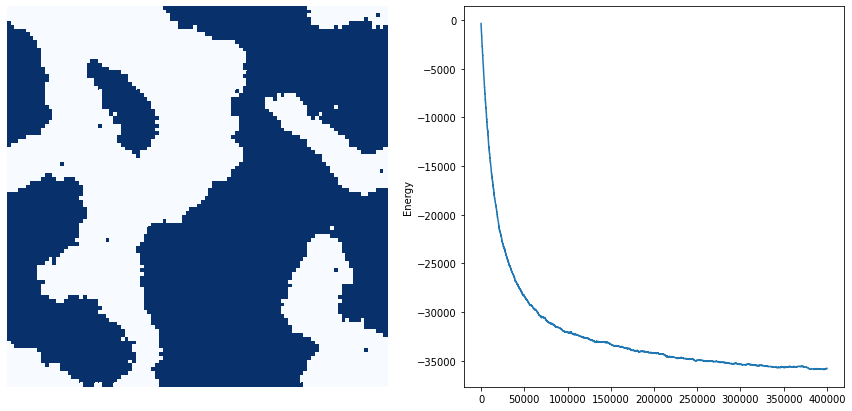

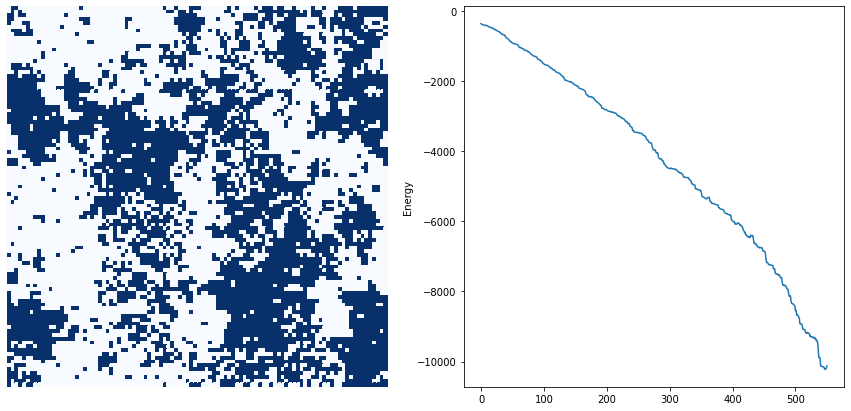

In [137]:
plot_lattice(thermalized_lattice_MC, E_MC)
plot_lattice(thermalized_lattice_cluster, E_cluster)

# Generating the data for the neural network

In [28]:
t1 = process_time()

N = 1000 # N configurations per temperature
L = 30 # size of the lattice

# number of steps for the cluster algorithm
n_steps_lowTemp = 15
n_steps_critTemp = 120
n_steps_largeTemp = 10

X = []  # lattice configurations
y = []   # class (low temp: 0, crit  temp: 1, large temp: 2)
yE = []   # energy of the configuration

for _ in range(N):
    # small temperature
    # the class will be denoted by 0
    lattice = spin_lattice(L)
    lattice_thermalized, E = cluster_algorithm(lattice, beta=beta_large, n_steps=n_steps_lowTemp)
    X.append(lattice_thermalized)
    y.append(0)
    yE.append(E[-1])
    
    # critical temperature
    # the class will be denoted by 1
    lattice = spin_lattice(L)
    lattice_thermalized, E = cluster_algorithm(lattice, beta=beta_critical, n_steps=n_steps_critTemp)
    X.append(lattice_thermalized)
    y.append(1)
    yE.append(E[-1])
    
    # large temperature
    # the class will be denoted by 2
    lattice = spin_lattice(L)
    lattice_thermalized, E = cluster_algorithm(lattice, beta=beta_small, n_steps=n_steps_largeTemp)
    X.append(lattice_thermalized)
    y.append(2)
    yE.append(E[-1])
    
X = np.array(X)
y = np.array(y)
yE = np.array(yE)

t2 = process_time()

print("It took %.2f seconds." % (t2-t1))

np.save("data_X", X)
np.save("data_y", y)
np.save("data_yE", yE)

It took 3328.26 seconds.


In [21]:
X = np.load("data_X.npy")
y = np.load("data_y.npy")
yE = np.load("data_yE.npy")

In [2]:
a = np.loadtxt('L_100.csv', delimiter=',', usecols=range(100**2))

In [3]:
a.shape

(7000, 10000)